In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [16]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((.5,.5,.5), (.5,.5,5))
])
train_data = torchvision.datasets.CIFAR10(root="../14-CNN Milestone Projects/cifar10", download=True, train=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root="../14-CNN Milestone Projects/cifar10", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [6]:
weights = torchvision.models.VGG16_Weights.DEFAULT
vgg = torchvision.models.vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/navsingh15/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:28<00:00, 19.2MB/s] 


In [7]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
for param in vgg.features.parameters():
    param.requires_grad = False

In [21]:
# Modify the classifier part of the VGG16 model
vgg.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 256),  # Adjust input size for the first FC layer
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(256, 128),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(128, 10),  # CIFAR-10 has 10 output classes
)

In [22]:
for p in vgg.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer features.0.weight: False
Requires_grad status in layer features.0.bias: False
Requires_grad status in layer features.2.weight: False
Requires_grad status in layer features.2.bias: False
Requires_grad status in layer features.5.weight: False
Requires_grad status in layer features.5.bias: False
Requires_grad status in layer features.7.weight: False
Requires_grad status in layer features.7.bias: False
Requires_grad status in layer features.10.weight: False
Requires_grad status in layer features.10.bias: False
Requires_grad status in layer features.12.weight: False
Requires_grad status in layer features.12.bias: False
Requires_grad status in layer features.14.weight: False
Requires_grad status in layer features.14.bias: False
Requires_grad status in layer features.17.weight: False
Requires_grad status in layer features.17.bias: False
Requires_grad status in layer features.19.weight: False
Requires_grad status in layer features.19.bias: False
Requires_grad stat

In [23]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
def trainModel(CNN, lossFunction, optimizer):

    epochs = 15

    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)
    trainErr = torch.zeros(epochs)
    testErr = torch.zeros(epochs)

    CNN.to(device)

    for _ in range(epochs):
        print(' ')    
        print("Epoch: ", _)

        CNN.train()

        batchLoss = []
        batchErr = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)

            yHat = CNN(X)

            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            yHat = yHat.cpu()
            y = y.cpu()

            batchLoss.append(loss.item())

            batchErr.append(torch.mean((torch.argmax(yHat, axis=1)!=y).float()).item()*100)

        trainLoss[_] = np.mean(batchLoss)
        trainErr[_] = np.mean(batchErr)

        CNN.eval()

        X, Y = next(iter(test_loader))

        X = X.to(device)
        Y = Y.to(device)

        with torch.no_grad():
            pred = CNN(X)
            loss = lossFunction(pred, Y)

        pred = pred.cpu()
        Y = Y.cpu()

        testLoss[_] = loss.item()
        testErr[_] = torch.mean((torch.argmax(pred, axis=1)!=Y).float()).item()*100

    return trainLoss,testLoss,trainErr,testErr,CNN

In [24]:
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)
trainLoss,testLoss,trainErr,testErr,net = trainModel(vgg, lossFunction, optimizer)

 
Epoch:  0
 
Epoch:  1
 
Epoch:  2
 
Epoch:  3
 
Epoch:  4
 
Epoch:  5
 
Epoch:  6
 
Epoch:  7
 
Epoch:  8
 
Epoch:  9
 
Epoch:  10
 
Epoch:  11
 
Epoch:  12
 
Epoch:  13
 
Epoch:  14


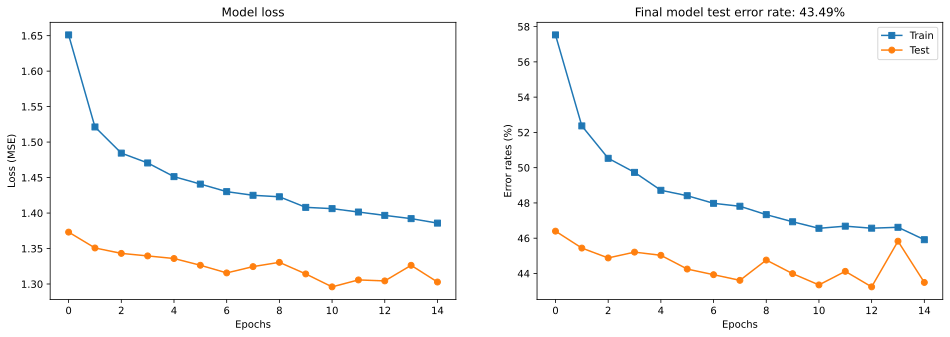

In [25]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()